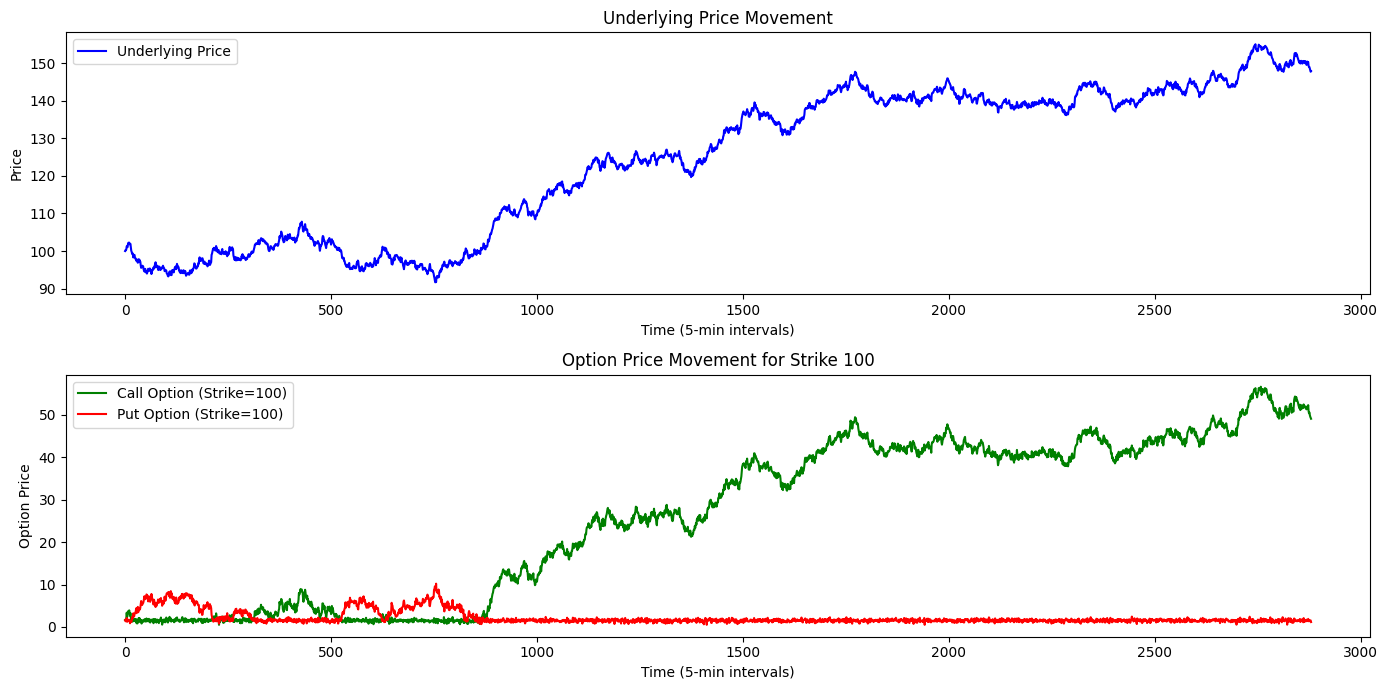

Option Decisions:
     Timestamp OptionType  Strike Action  Quantity Classification  \
0        2199        Put     101    Buy         8            Bad   
1         258       Call      97    Buy         9           Good   
2        2751       Call     106    Buy        10            Bad   
3         544       Call      98    Buy         6           Good   
4        2690       Call     100   Sell         5           Good   
5         628       Call     104   Sell         4            Bad   
6        1583       Call     101   Sell         7           Good   
7         780       Call      93   Sell         4            Bad   
8        1822        Put     105   Sell         9            Bad   
9         572        Put      91   Sell         6            Bad   
10       1055        Put     103    Buy         7            Bad   
11         26       Call     108   Sell         2            Bad   
12       1869       Call     110    Buy        10            Bad   
13       2562       Call     

In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# Parameters for synthetic data generation
days = 10
intervals_per_day = 12 * 24  # 5-minute intervals in a day
strike_price = 100
click_range = 10

# Generate synthetic underlying price movements (random walk)
np.random.seed(42)
underlying_prices = [strike_price]
for _ in range(days * intervals_per_day - 1):
    movement = np.random.normal(0, 0.5)
    underlying_prices.append(underlying_prices[-1] + movement)

# Generate option prices (call and put) based on underlying price
call_prices = []
put_prices = []
for price in underlying_prices:
    for i in range(-click_range, click_range + 1):
        strike = strike_price + i
        intrinsic_value_call = max(0, price - strike)
        intrinsic_value_put = max(0, strike - price)
        
        # Add extrinsic value (volatility skew and random noise)
        extrinsic_value = max(0.5, np.random.normal(1.5, 0.3))
        call_prices.append({
            "Underlying": price,
            "Strike": strike,
            "OptionType": "Call",
            "Price": intrinsic_value_call + extrinsic_value
        })
        put_prices.append({
            "Underlying": price,
            "Strike": strike,
            "OptionType": "Put",
            "Price": intrinsic_value_put + extrinsic_value
        })

# Combine into a DataFrame
option_data = pd.DataFrame(call_prices + put_prices)

# Simulate 20 random buy/sell decisions over 10 days
decisions = []
for _ in range(20):
    decision = {
        "Timestamp": random.randint(0, len(underlying_prices) - 1),
        "OptionType": random.choice(["Call", "Put"]),
        "Strike": random.choice(range(strike_price - click_range, strike_price + click_range + 1)),
        "Action": random.choice(["Buy", "Sell"]),
        "Quantity": random.randint(1, 10)
    }
    decisions.append(decision)

decision_df = pd.DataFrame(decisions)

# Classify decisions (Good, Neutral, Bad) based on historical data
def classify_decision(row):
    # Retrieve matching option data
    relevant_option = option_data[(option_data['Strike'] == row['Strike']) &
                                   (option_data['OptionType'] == row['OptionType'])]
    if relevant_option.empty:
        return "Neutral", "No matching option data"

    current_price = relevant_option.iloc[row['Timestamp']]['Price']
    historical_prices = relevant_option.loc[:row['Timestamp'], 'Price']
    mean_price = historical_prices.mean()

    # Evaluate decision based on historical mean price
    if row['Action'] == "Buy":
        if current_price < mean_price:  # Buying below historical average price
            return "Good", "Price below historical average"
        elif current_price == mean_price:
            return "Neutral", "Price equals historical average"
        else:
            return "Bad", "Price above historical average"
    else:  # Sell
        if current_price > mean_price:  # Selling above historical average price
            return "Good", "Price above historical average"
        elif current_price == mean_price:
            return "Neutral", "Price equals historical average"
        else:
            return "Bad", "Price below historical average"

# Apply classification
decision_df[['Classification', 'Note']] = decision_df.apply(
    classify_decision, axis=1, result_type="expand")

# Plot graphs for better understanding
plt.figure(figsize=(14, 7))

# Underlying price trend
plt.subplot(2, 1, 1)
plt.plot(underlying_prices, label="Underlying Price", color="blue")
plt.title("Underlying Price Movement")
plt.xlabel("Time (5-min intervals)")
plt.ylabel("Price")
plt.legend()

# Sample option price trend for a single strike
sample_strike = strike_price
call_prices_sample = option_data[(option_data['Strike'] == sample_strike) & (option_data['OptionType'] == "Call")]
put_prices_sample = option_data[(option_data['Strike'] == sample_strike) & (option_data['OptionType'] == "Put")]

plt.subplot(2, 1, 2)
plt.plot(call_prices_sample['Price'].values, label=f"Call Option (Strike={sample_strike})", color="green")
plt.plot(put_prices_sample['Price'].values, label=f"Put Option (Strike={sample_strike})", color="red")
plt.title(f"Option Price Movement for Strike {sample_strike}")
plt.xlabel("Time (5-min intervals)")
plt.ylabel("Option Price")
plt.legend()

plt.tight_layout()
plt.show()

# Output
print("Option Decisions:\n", decision_df)
